### Reference

- https://github.com/usuyama/pytorch-unet

We should also check: https://github.com/milesial/Pytorch-UNet


In [ ]:
# download the repo to Jupyterhub using:
# !git clone https://github.com/BIDS/BSDS500.git

## Preprocessing

In [1]:
import cv2
import matplotlib.pyplot as plt
import scipy.io
import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

folder = 'BSR_unzip/BSR/BSDS500/data/'

def load_images(folder):
    images = []
    files = os.listdir(folder)
    files = [i for i in files if '.jpg' in i]
    files.sort()
    for filename in files:
        img = cv2.imread(os.path.join(folder,filename))
        if img.shape == (481, 321, 3):
            img = np.transpose(img, (1, 0, 2)) 
        ## do padding
        #img = np.pad(img, ((0, 1), (0, 1), (0, 0)), mode='constant', constant_values=0)
        # do cropping
        img = img[:320, :480, :]
        if img is not None:
            images.append(img)
    return images

def load_labels(folder):
    labels = []
    files = os.listdir(folder)
    files.sort()
    for filename in files:
        gts_len = len((scipy.io.loadmat(os.path.join(folder,filename)))['groundTruth'][0])
        gt_majority = np.zeros((scipy.io.loadmat(os.path.join(folder,filename)))['groundTruth'][0][0][0][0][1].shape)
        for i in range(gts_len):
            label = (scipy.io.loadmat(os.path.join(folder,filename)))['groundTruth'][0][i][0][0][1]
            label = np.where(label == 0, -1, 1)
            gt_majority += label
        gt_majority = np.where(gt_majority >= 0, 1, 0)
        if gt_majority.shape == (481, 321):
            gt_majority = gt_majority.T
        ## do padding
        #gt_majority = np.pad(gt_majority, ((0, 1), (0, 1)), mode='constant', constant_values=0)
        # do cropping
        gt_majority = gt_majority[:320, :480]
        labels.append(gt_majority)
            
    return labels

# Load Images
xtrain = load_images(folder + 'images/train')
xtest = load_images(folder + 'images/test')
xval = load_images(folder + 'images/val')

# Load Ground Truths Using Majority Vote Notion
ytrain = load_labels(folder + 'groundTruth/train')
ytest = load_labels(folder + 'groundTruth/test')
yval = load_labels(folder + 'groundTruth/val')

#plt.imshow(xtrain[0])
#plt.imshow(ytrain[0])
#
#plt.imshow(xtrain[1])
#plt.imshow(ytrain[1])

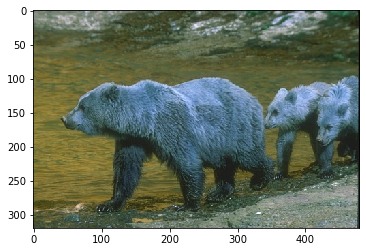

In [2]:
plt.imshow(xtrain[0])

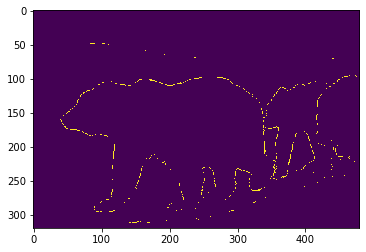

In [3]:
plt.imshow(ytrain[0])

In [4]:
# Stack images along a new axis

xtrain = np.vstack([i[None, :, :, :] for i in xtrain])
xtest = np.vstack([i[None, :, :, :] for i in xtest])
xval = np.vstack([i[None, :, :, :] for i in xval])

xtrain.shape, xtest.shape, xval.shape

((200, 320, 480, 3), (200, 320, 480, 3), (100, 320, 480, 3))

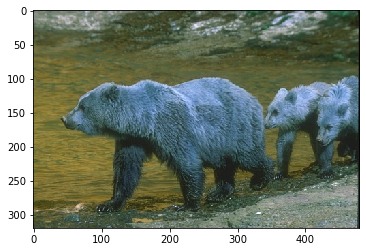

In [5]:
plt.imshow(xtrain[0, :, :, :])

In [6]:
# Stack labels along a new axis

ytrain = np.vstack([i[None, :, :] for i in ytrain])
ytest = np.vstack([i[None, :, :] for i in ytest])
yval = np.vstack([i[None, :, :] for i in yval])

ytrain.shape, ytest.shape, yval.shape

((200, 320, 480), (200, 320, 480), (100, 320, 480))

In [7]:
## Create tensors from images
import torch

xtrain = torch.from_numpy(np.transpose(xtrain, [0, 3, 1, 2]))
xtest = torch.from_numpy(np.transpose(xtest, [0, 3, 1, 2]))
xval = torch.from_numpy(np.transpose(xval, [0, 3, 1, 2]))

xtrain.shape, xtest.shape, xval.shape

(torch.Size([200, 3, 320, 480]),
 torch.Size([200, 3, 320, 480]),
 torch.Size([100, 3, 320, 480]))

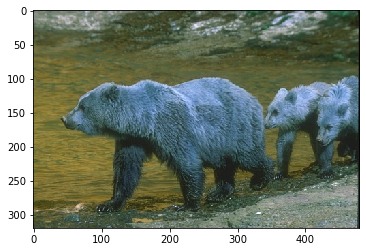

In [8]:
plt.imshow(np.transpose(xtrain.numpy()[0, :, :, :], [1, 2, 0]))

In [9]:
## Create tensors from labels
ytrain = torch.from_numpy(ytrain).view(200, 1, 320, 480)
ytest = torch.from_numpy(ytest).view(200, 1, 320, 480)
yval = torch.from_numpy(yval).view(100, 1, 320, 480)

ytrain.shape, ytest.shape, yval.shape

(torch.Size([200, 1, 320, 480]),
 torch.Size([200, 1, 320, 480]),
 torch.Size([100, 1, 320, 480]))

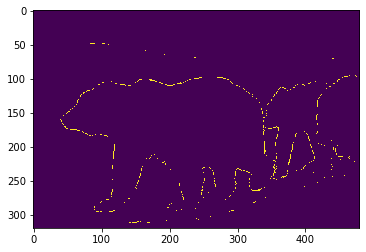

In [10]:
plt.imshow(ytrain[0,0,:,:])

In [11]:
# change data types
xtrain = xtrain.type('torch.FloatTensor')
xtest = xtest.type('torch.FloatTensor')
xval = xval.type('torch.FloatTensor')

ytrain = ytrain.type('torch.FloatTensor')
ytest = ytest.type('torch.FloatTensor')
yval = yval.type('torch.FloatTensor')

In [12]:
# Adjust data, make it usable for dataloader
train_set = [[xtrain[i, :, :, :], ytrain[i, :, :]] for i in range(xtrain.shape[0])]
test_set = [[xtest[i, :, :, :], ytest[i, :, :]] for i in range(xtest.shape[0])]
val_set = [[xval[i, :, :, :], yval[i, :, :]] for i in range(xval.shape[0])]

In [13]:
train_set[0][0].shape, train_set[0][1].shape

(torch.Size([3, 320, 480]), torch.Size([1, 320, 480]))

In [14]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 1

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 200, 'val': 100}

## Training

In [15]:
# Define U-net Model

import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        #out = torch.sigmoid(out)
        
        return out

In [16]:
from torchsummary import summary
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(1)
model = model.to(device)

summary(model, input_size=(3, 320, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 480]           1,792
              ReLU-2         [-1, 64, 320, 480]               0
            Conv2d-3         [-1, 64, 320, 480]          36,928
              ReLU-4         [-1, 64, 320, 480]               0
         MaxPool2d-5         [-1, 64, 160, 240]               0
            Conv2d-6        [-1, 128, 160, 240]          73,856
              ReLU-7        [-1, 128, 160, 240]               0
            Conv2d-8        [-1, 128, 160, 240]         147,584
              ReLU-9        [-1, 128, 160, 240]               0
        MaxPool2d-10         [-1, 128, 80, 120]               0
           Conv2d-11         [-1, 256, 80, 120]         295,168
             ReLU-12         [-1, 256, 80, 120]               0
           Conv2d-13         [-1, 256, 80, 120]         590,080
             ReLU-14         [-1, 256, 

In [17]:
from collections import defaultdict
import torch.nn.functional as F

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1

model = UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

cuda:0
Epoch 0/39
----------
LR 0.0001


/home/iocak/.local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/iocak/.local/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.086076, dice: 0.982145, loss: 0.534110
val: bce: 0.065877, dice: 0.943113, loss: 0.504495
saving best model
0m 14s
Epoch 1/39
----------
LR 0.0001
train: bce: 0.072566, dice: 0.919202, loss: 0.495884
val: bce: 0.053611, dice: 0.905228, loss: 0.479419
saving best model
0m 14s
Epoch 2/39
----------
LR 0.0001
train: bce: 0.064162, dice: 0.850383, loss: 0.457273
val: bce: 0.047844, dice: 0.844751, loss: 0.446297
saving best model
0m 14s
Epoch 3/39
----------
LR 0.0001
train: bce: 0.058338, dice: 0.818571, loss: 0.438455
val: bce: 0.050402, dice: 0.810807, loss: 0.430604
saving best model
0m 14s
Epoch 4/39
----------
LR 0.0001
train: bce: 0.054620, dice: 0.800093, loss: 0.427357
val: bce: 0.044772, dice: 0.793310, loss: 0.419041
saving best model
0m 14s
Epoch 5/39
----------
LR 0.0001
train: bce: 0.053390, dice: 0.791253, loss: 0.422321
val: bce: 0.048806, dice: 0.795438, loss: 0.422122
0m 14s
Epoch 6/39
----------
LR 0.0001
train: bce: 0.052559, dice: 0.780830, loss: 0.416695

## Prediction

In [51]:
# prediction for 1 instance

import math

model.eval()   # Set model to evaluate mode

test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
pred = pred[0, 0, :, :]
pred = np.where(pred>=0.5, 1, 0)

gt = ytest.numpy()[0, 0, :, :]

org = np.transpose(xtest.numpy()[0, :, :, :], [1, 2, 0]).astype(int)

In [73]:
# accuracy
accuracy = np.sum(pred == gt) / (gt.shape[0] * gt.shape[1])

# precision
tp = np.sum(pred[np.where(pred == 1)] == gt[np.where(pred == 1)])
fp = np.sum(pred[np.where(pred == 1)] != gt[np.where(pred == 1)])
precision = tp / (tp + fp)

# recall
fn = np.sum(pred[np.where(pred == 0)] != gt[np.where(pred == 0)])
recall = tp / (tp + fn)

# f-value
fvalue = 2 * precision * recall / (precision + recall)

In [83]:
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F-value: {fvalue}')

Accuracy: 0.9899153645833333, Precision: 0.3114754098360656, Recall: 0.40076701821668265, F-value: 0.3505241090146751


Text(0.5, 1.0, 'Pred')

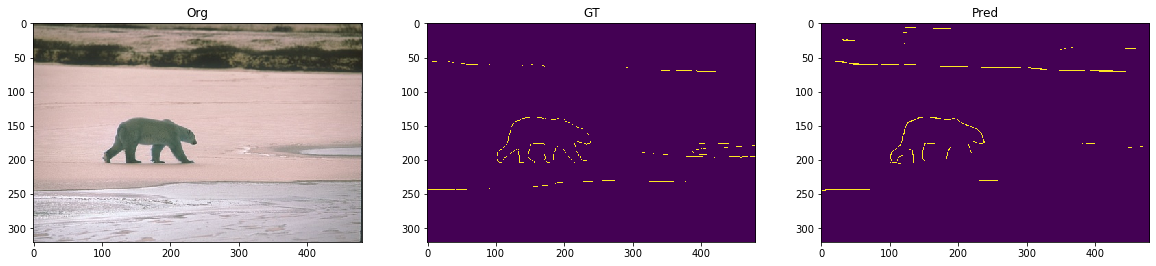

In [52]:
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org)
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt)
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(pred)
plt.title('Pred')

In [95]:
num_it = len(test_set)

model.eval()   # Set model to evaluate mode

test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)
iterator = iter(test_loader)

org_list = []
gt_list = []
pred_list = []
accuracy_list = []
precision_list = []
recall_list = []
fvalue_list = []

for i in range(num_it):
    inputs, labels = next(iterator)
    inputs = inputs.to(device)
    labels = labels.to(device)

    pred = model(inputs)
    pred = torch.sigmoid(pred)
    pred = pred.data.cpu().numpy()
    pred = pred[0, 0, :, :]
    
    # arrays
    pred = np.where(pred>=0.5, 1, 0)
    gt = ytest.numpy()[i, 0, :, :]
    org = np.transpose(xtest.numpy()[i, :, :, :], [1, 2, 0]).astype(int)
    
    # metrics
    # accuracy
    accuracy = np.sum(pred == gt) / (gt.shape[0] * gt.shape[1])

    # precision
    tp = np.sum(pred[np.where(pred == 1)] == gt[np.where(pred == 1)])
    fp = np.sum(pred[np.where(pred == 1)] != gt[np.where(pred == 1)])
    precision = tp / (tp + fp)

    # recall
    fn = np.sum(pred[np.where(pred == 0)] != gt[np.where(pred == 0)])
    recall = tp / (tp + fn)

    # f-value
    if (precision == 0) & (recall == 0):
        fvalue = 0
    else:
        fvalue = 2 * precision * recall / (precision + recall)
    
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F-value: {fvalue}')
    
    org_list.append(org)
    gt_list.append(gt)
    pred_list.append(pred)
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    fvalue_list.append(fvalue)

Accuracy: 0.9899153645833333, Precision: 0.3114754098360656, Recall: 0.40076701821668265, F-value: 0.3505241090146751
Accuracy: 0.9945768229166667, Precision: 0.2534013605442177, Recall: 0.27440147329650094, F-value: 0.26348364279398767
Accuracy: 0.9957356770833333, Precision: 0.239067055393586, Recall: 0.1722689075630252, F-value: 0.20024420024420023
Accuracy: 0.9873307291666666, Precision: 0.18700564971751413, Recall: 0.39498806682577564, F-value: 0.25383435582822084
Accuracy: 0.99328125, Precision: 0.21397379912663755, Recall: 0.2300469483568075, F-value: 0.22171945701357465
Accuracy: 0.9856184895833333, Precision: 0.45340909090909093, Recall: 0.3902200488997555, F-value: 0.41944809461235216
Accuracy: 0.9900130208333333, Precision: 0.21015514809590974, Recall: 0.13268032056990206, F-value: 0.1626637554585153
Accuracy: 0.9889453125, Precision: 0.1354916067146283, Recall: 0.46887966804979253, F-value: 0.21023255813953487
Accuracy: 0.9940299479166667, Precision: 0.5441176470588235, Rec

Accuracy: 0.9899739583333333, Precision: 0.2289156626506024, Recall: 0.25863874345549737, F-value: 0.24287118977384461
Accuracy: 0.9948177083333334, Precision: 0.2230769230769231, Recall: 0.08895705521472393, F-value: 0.12719298245614036
Accuracy: 0.97849609375, Precision: 0.5432835820895522, Recall: 0.31406384814495253, F-value: 0.39803171131765985
Accuracy: 0.9870247395833334, Precision: 0.44798500468603564, Recall: 0.25398512221041447, F-value: 0.32417768735164465
Accuracy: 0.9843098958333333, Precision: 0.4260267194458189, Recall: 0.4078635717669351, F-value: 0.41674733785091966
Accuracy: 0.9897135416666667, Precision: 0.31702412868632707, Recall: 0.4574468085106383, F-value: 0.3745051464766429
Accuracy: 0.9904296875, Precision: 0.25704225352112675, Recall: 0.20738636363636365, F-value: 0.22955974842767296
Accuracy: 0.98654296875, Precision: 0.3712041884816754, Recall: 0.45015873015873015, F-value: 0.40688665710186517
Accuracy: 0.9909700520833333, Precision: 0.2536842105263158, Rec

Accuracy: 0.9944466145833334, Precision: 0.16381418092909536, Recall: 0.11591695501730104, F-value: 0.13576494427558256
Accuracy: 0.9843489583333334, Precision: 0.3579610538373425, Recall: 0.3275681341719078, F-value: 0.34209085933223865
Accuracy: 0.981171875, Precision: 0.295873573309921, Recall: 0.1388545529460239, F-value: 0.18900729108244532
Accuracy: 0.9812630208333334, Precision: 0.34371643394199786, Recall: 0.2787456445993031, F-value: 0.30784030784030786
Accuracy: 0.9900911458333334, Precision: 0.31605562579013907, Recall: 0.5319148936170213, F-value: 0.39651070578905634
Accuracy: 0.9874739583333333, Precision: 0.3331570597567425, Recall: 0.4872389791183295, F-value: 0.3957286432160804
Accuracy: 0.9853125, Precision: 0.3203688853247795, Recall: 0.5875, F-value: 0.41463414634146345
Accuracy: 0.9885026041666667, Precision: 0.15405651777575205, Recall: 0.16782522343594836, F-value: 0.1606463878326996
Accuracy: 0.9920442708333334, Precision: 0.36610169491525424, Recall: 0.328934010

In [92]:
metrics = pd.DataFrame({'accuracy' : accuracy_list,
                        'precision' : precision_list,
                        'recall' : recall_list,
                        'fscore' : fvalue_list})

In [94]:
metrics.mean()

accuracy     0.989162
precision    0.268491
recall       0.251050
fscore       0.248153
dtype: float64

Text(0.5, 1.0, 'Pred')

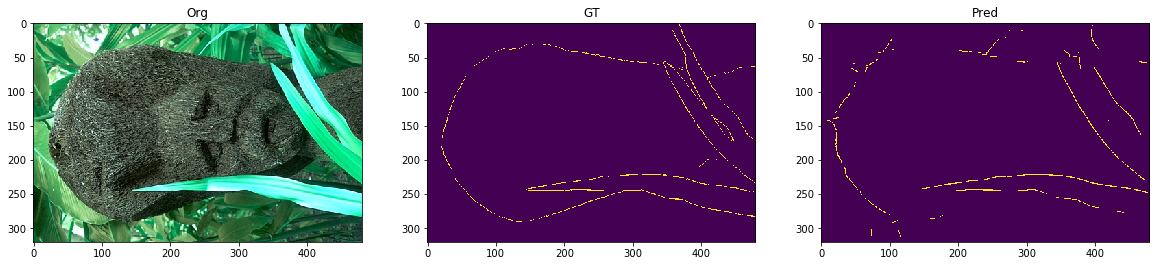

In [100]:
# Inspect some images
index = 5
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(pred_list[index])
plt.title('Pred')